# **Cross-Entropy fo Reinforcement Learning**

Given a set of inputs, the algorithm sees the outputs produced, chooses the inputs that have led to the best outputs and tunes them till it is satisfied with the outputs. [Full article](https://towardsdatascience.com/cross-entropy-method-for-reinforcement-learning-2b6de2a4f3a0).

In this notebook, we will train the Cross-Entropy Method with OpenAI Gym's MountainCarContinuous environment.
([code on github](https://github.com/udacity/deep-reinforcement-learning/tree/master/cross-entropy)).

**Note on environment choices**
The current code only works on continuous environments and will throw errors if you try a discrete environment. [Gym](https://gym.openai.com/envs/) has a lot of continuous environments like gym's *Pendulum-v1*.

**Install needed packages**

Note: if your example problem requires packages that are not installed, please contact youru instructor to install them for you.

In [1]:
# Avoid multiple installation of packages on Ed
import os
if not os.getenv("ED_COURSE_ID"):
    !pip install torch  collections gym

**1. Import the Necessary Packages**

In [2]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

**2. Instantiate the Environment and Agent**


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box([-1.], [1.], (1,), float32)
  - low: [-1.]
  - high: [1.]


**3. Train the Agent with the Cross-Entropy Method**

Run the code cell below to train the agent from scratch. Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

/usr/lib/python3.9/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -1.44
Episode 20	Average Score: -3.98
Episode 30	Average Score: -4.18
Episode 40	Average Score: 2.57
Episode 50	Average Score: 18.74
Episode 60	Average Score: 29.35
Episode 70	Average Score: 38.69
Episode 80	Average Score: 45.65
Episode 90	Average Score: 47.98
Episode 100	Average Score: 52.56
Episode 110	Average Score: 62.09
Episode 120	Average Score: 72.28
Episode 130	Average Score: 82.21
Episode 140	Average Score: 89.48

Environment solved in 47 iterations!	Average Score: 90.83


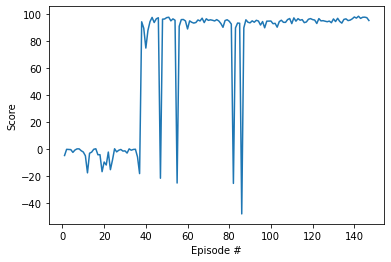

In [4]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

**4. Watch a Smart Agent!**

In the next code cell, you will load the trained weights from file to watch a smart agent!

**Note on visualization**: If the display window comes up but the environment is not displayed, please click on the "..." on the top right of the window to select "Full view", then click on the "Remote App" button (with a blue dot) to view the rendering. The environment only shows through the duration of the while loop. If the window closes, you can rerun this section (Ctrl+Enter), and click on the remote app button, to view the display again.

In [5]:
!xdpyinfo
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

name of display:    :1.0
version number:    11.0
vendor string:    The X.Org Foundation
vendor release number:    12009000
X.Org version: 1.20.9
maximum request size:  16777212 bytes
motion buffer size:  256
bitmap unit, bit order, padding:    32, LSBFirst, 32
image byte order:    LSBFirst
number of supported pixmap formats:    6
supported pixmap formats:
    depth 1, bits_per_pixel 1, scanline_pad 32
    depth 4, bits_per_pixel 8, scanline_pad 32
    depth 8, bits_per_pixel 8, scanline_pad 32
    depth 16, bits_per_pixel 16, scanline_pad 32
    depth 24, bits_per_pixel 32, scanline_pad 32
    depth 32, bits_per_pixel 32, scanline_pad 32
keycode range:    minimum 8, maximum 255
focus:  PointerRoot
number of extensions:    23
    BIG-REQUESTS
    Composite
    DAMAGE
    DOUBLE-BUFFER
    GLX
    Generic Event Extension
    MIT-SCREEN-SAVER
    MIT-SHM
    Present
    RANDR
    RECORD
    RENDER
    SHAPE
    SYNC
    VNC-EXTENSION
    X-Resource
    XC-MISC
    XFIXES
    XINERAMA
    

/usr/lib/python3.9/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
